# Proyecto - Seminario de Sistemas 2 - Fase 2
# EDA Monovariable y Multivariable

## Lectura de Datos (SQL Server -> Pandas Dataframe) + Importaciones

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine


In [2]:
# Configuración de conexión a SQL Server
server = 'FROI-PC\\SQLEXPRESS'
database = 'covid-data'
trusted_connection = 'yes'

# Especificar el controlador de pyodbc en la cadena de conexión
conn_str = f'mssql+pyodbc://{server}/{database}?trusted_connection={trusted_connection}&driver=ODBC+Driver+17+for+SQL+Server'

# Crear el motor de SQLAlchemy
engine = create_engine(conn_str)

# Consulta SQL para extraer datos
sql_query_municipality = 'SELECT * FROM MUNICIPALITY'
sql_query_department = 'SELECT * FROM DEPARTMENT'
sql_query_municipality_deaths = 'SELECT MD.municipality_code, MD.date, MD.total_deaths, MD.day_deaths, M.name AS \'municipality_name\', D.name AS \'department_name\' FROM MUNICIPALITY_DEATHS AS MD LEFT JOIN MUNICIPALITY AS M ON MD.municipality_code=M.code LEFT JOIN DEPARTMENT AS D ON M.department_code=D.code'
sql_query_country_deaths = 'SELECT * FROM COUNTRY_DEATHS'
sql_query_department_population = 'SELECT D.[code] AS DepartmentCode, D.[name] AS DepartmentName, SUM(M.[population]) AS TotalPopulation FROM [dbo].[DEPARTMENT] D JOIN [dbo].[MUNICIPALITY] M ON D.[code] = M.[department_code] GROUP BY D.[code], D.[name] ORDER BY CONVERT(INT, D.[code]);'

# Ejecutar la consulta y cargar los resultados en DataFrames
df_municipality = pd.read_sql(sql_query_municipality, engine)
df_department = pd.read_sql(sql_query_department, engine)
df_municipality_deaths = pd.read_sql(sql_query_municipality_deaths, engine)
df_country_deaths = pd.read_sql(sql_query_country_deaths, engine)
df_department_population = pd.read_sql(sql_query_department_population, engine)

# Asegurar que la columna 'date' sea de tipo datetime64[ns]
df_country_deaths['date'] = pd.to_datetime(df_country_deaths['date'])

# Filtrar registros directamente en el mismo DataFrame
df_country_deaths = df_country_deaths[df_country_deaths['date'] > '2020-03-15']

## Tablas (Estructura)

### Municipios

In [3]:
df_municipality.head(4)
df_municipality.tail(4)

code                    name department_code  population
333  921                  GENOVA               9       45162
334  922       FLORES COSTA CUCA               9       23851
335  923            LA ESPERANZA               9       24199
336  924  PALESTINA DE LOS ALTOS               9       20299

### Departamentos

In [4]:
df_department.head(4)
df_department.tail(4)

code            name
18    6      SANTA ROSA
19    7          SOLOLA
20    8     TOTONICAPAN
21    9  QUETZALTENANGO

### Muertes por municipio

In [5]:
df_municipality_deaths.head(4)
df_municipality_deaths.tail(4)

municipality_code       date  total_deaths  day_deaths  \
85931               924 2020-12-28             0         138   
85932               924 2020-12-29             0         132   
85933               924 2020-12-30             0         846   
85934               924 2020-12-31             0         879   

            municipality_name department_name  
85931  PALESTINA DE LOS ALTOS  QUETZALTENANGO  
85932  PALESTINA DE LOS ALTOS  QUETZALTENANGO  
85933  PALESTINA DE LOS ALTOS  QUETZALTENANGO  
85934  PALESTINA DE LOS ALTOS  QUETZALTENANGO

### Muertes a Nivel Nacional

In [6]:
df_country_deaths.head(4)
df_country_deaths.tail(4)

date country_code  new_cases  cumulative_cases  new_deaths  \
357 2020-12-28           GT        138            135309           5   
358 2020-12-29           GT        132            135441           5   
359 2020-12-30           GT        846            136287           8   
360 2020-12-31           GT        879            137166          22   

     cumulative_deaths  
357               4768  
358               4773  
359               4781  
360               4803

### Población Departamental

In [7]:
df_department_population.tail(4)

DepartmentCode DepartmentName  TotalPopulation
18             19         ZACAPA           267718
19             20     CHIQUIMULA           441579
20             21         JALAPA           394234
21             22        JUTIAPA           546005

## EDA Monovariable

### Análisis de Nuevas Muertes

#### Observaciones
- El valor promedio de new_deaths es de 15 (redondeado)
- Los valores más frecuentes de esta variable son valores relativamente bajos (entre 0 y 20)
- Que los valores más frecuentes sean relativamente bajos se puede visualizar tanto en el histograma como en el diagrama de caja, ya que se puede visualizar que los valores que están entre el cuartil 3 y el 1 son precisamente los que componen la caja


In [8]:
# Estadísticas Descriptivas
describe = df_country_deaths['new_deaths'].describe()
print(f"Estadísticas descriptivas\n{describe}\n")

# Estadísticas de Conteo
count = df_country_deaths['new_deaths'].count()
print(f"Estadísticas de Conteo\n{count}\n")

# Valores únicos
unique = df_country_deaths['new_deaths'].unique()
nunique = df_country_deaths['new_deaths'].nunique()
print(f"Valores Únicos\n{unique}")
print(f"Valores Únicos (cantidad): {nunique}\n")
# Promedio
mean = df_country_deaths['new_deaths'].mean()
print(f"Promedio\n{mean}\n")

# Cuartiles
# Mediana (50%)
median_new_deaths = df_country_deaths['new_deaths'].median()

# Cuartiles (25%, 75%)
q1_new_deaths = df_country_deaths['new_deaths'].quantile(0.25)
q3_new_deaths = df_country_deaths['new_deaths'].quantile(0.75)

print("\nMediana para 'new_deaths':", median_new_deaths)
print("\nCuartil 25% para 'new_deaths':", q1_new_deaths)
print("\nCuartil 75% para 'new_deaths':", q3_new_deaths)

Estadísticas descriptivas
count    288.000000
mean      16.684028
std       14.775468
min        0.000000
25%        4.000000
50%       14.000000
75%       25.250000
max       61.000000
Name: new_deaths, dtype: float64

Estadísticas de Conteo
288

Valores Únicos
[ 0  1  2  3  5  4 12 10  6  8  7 20 15 58 14 22 27 18 17 16 19 34 31 35
 49 21 44 26 37 40 23 39 47 33 25 48 54 53 29 42 59 30 32 57 38 24 11 45
 28 13  9 61 41]
Valores Únicos (cantidad): 53

Promedio
16.68402777777778


Mediana para 'new_deaths': 14.0

Cuartil 25% para 'new_deaths': 4.0

Cuartil 75% para 'new_deaths': 25.25


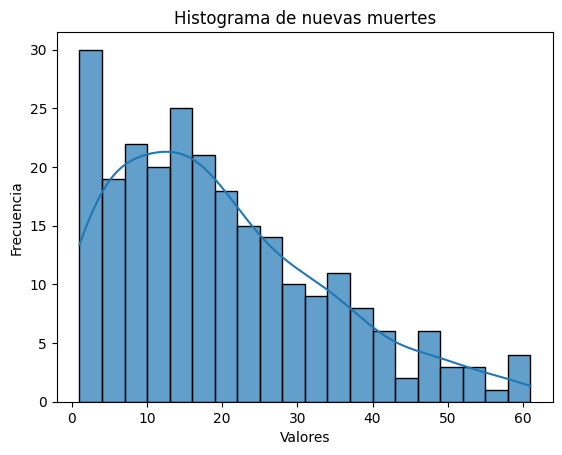

In [9]:
# Filtra los valores mayores que cero
filtered_data = df_country_deaths['new_deaths'][df_country_deaths['new_deaths'] > 0]

# Crea el histograma con la transformación logarítmica
sns.histplot(filtered_data, bins=20, kde=True, edgecolor='black', alpha=0.7)
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Histograma de nuevas muertes')
plt.show()

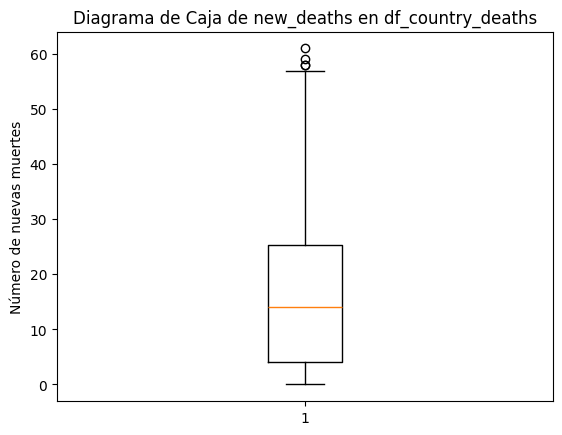

In [10]:
plt.boxplot(df_country_deaths['new_deaths'])

plt.title('Diagrama de Caja de new_deaths en df_country_deaths')
plt.ylabel('Número de nuevas muertes')
plt.show()

### Análisis de Cantidad de Muertes Acumuladas

#### Observaciones
- En la variable de muertes acumuladas se puede ver una mejor distribución de los datos, ya que los cuartiles están un poco más proporcionados exceptuando los datos del primer cuartil. Esto se puede deber a que por mucho tiempo la población Guatemalteca acató medidas de prevención de tal forma que no hubieron muchos contagios al inicio.
- El promedio es de 2017 un valor que puede ser considerado muy alto, sin embargo, debido a que se trata de estadísticas acumulativas, es entendible que este valor sea alto.
- El total de registros es de 288 los cuales concuerdan con los días en que se registraron muertes por covid y aquellos datos que pasaron la limpieza de datos hecha anteriormente

In [11]:
# Estadísticas Descriptivas
describe = df_country_deaths['cumulative_deaths'].describe()
print(f"Estadísticas descriptivas\n{describe}\n")

# Estadísticas de Conteo
count = df_country_deaths['cumulative_deaths'].count()
print(f"Estadísticas de Conteo\n{count}\n")

# Valores únicos
unique = df_country_deaths['cumulative_deaths'].nunique()
print(f"Valores Únicos\n{unique}\n")

# Promedio
mean = df_country_deaths['cumulative_deaths'].mean()
print(f"Promedio\n{mean}\n")

# Cuartiles
# Mediana (50%)
median_new_deaths = df_country_deaths['cumulative_deaths'].median()

# Cuartiles (25%, 75%)
q1_new_deaths = df_country_deaths['cumulative_deaths'].quantile(0.25)
q3_new_deaths = df_country_deaths['cumulative_deaths'].quantile(0.75)

print("\nMediana para 'cumulative_deaths':", median_new_deaths)
print("\nCuartil 25% para 'cumulative_deaths':", q1_new_deaths)
print("\nCuartil 75% para 'cumulative_deaths':", q3_new_deaths)

Estadísticas descriptivas
count     288.000000
mean     2017.288194
std      1669.618975
min         0.000000
25%        77.000000
50%      2204.000000
75%      3542.250000
max      4803.000000
Name: cumulative_deaths, dtype: float64

Estadísticas de Conteo
288

Valores Únicos
249

Promedio
2017.2881944444443


Mediana para 'cumulative_deaths': 2204.0

Cuartil 25% para 'cumulative_deaths': 77.0

Cuartil 75% para 'cumulative_deaths': 3542.25


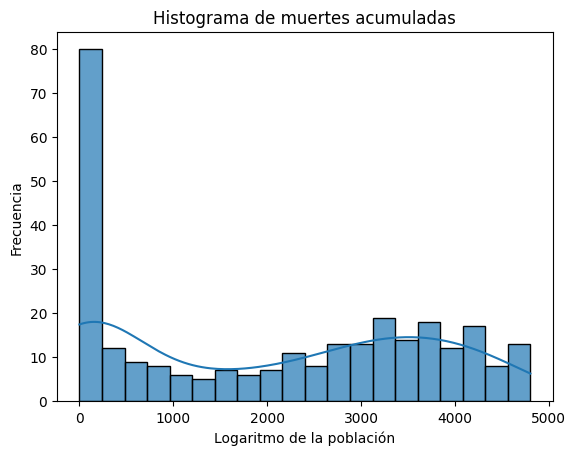

In [12]:
# Filtra los valores mayores que cero
filtered_data = df_country_deaths['cumulative_deaths'][df_country_deaths['cumulative_deaths'] > 0]

sns.histplot(filtered_data, bins=20, kde=True, edgecolor='black', alpha=0.7)
plt.xlabel('Logaritmo de la población')
plt.ylabel('Frecuencia')
plt.title('Histograma de muertes acumuladas')
plt.show()

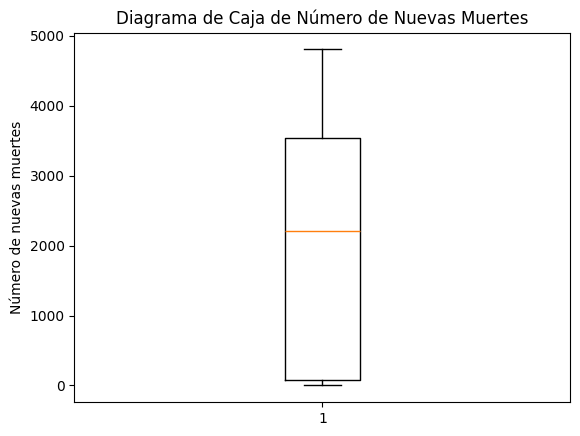

In [13]:
plt.boxplot(df_country_deaths['cumulative_deaths'])

plt.title('Diagrama de Caja de Número de Nuevas Muertes')
plt.ylabel('Número de nuevas muertes')
plt.show()

### Análisis de Población en los Municipios

#### Observaciones
- Probablemente la estadística más controversial, ya que los valores tienen una separación muy grande. Esto se debe a la población en el país de Guatemala, un número muy grande de habitantes suele concentrase en ciudades muy específicas como lo pueden ser la Ciudad de Guatemala, Mixco, Villa Nueva, etc.
- Si comparamos la población de los municipios anteriormente mencionados con algunos otros municipios del área rural, hay una diferencia de población muy grande. Y es importante tomar en cuenta que el área rural comprende la mayor parte del territorio de la República, por lo cual es entendible que tanto la gráfica de caja como la gráfica inicial del histograma posean dicha forma.
- Como se mencionó, la gráfica inicial que tenía el histograma tenía una forma extraña, a tal punto que la misma estaba sesgada. Por lo cual se tuvo que aplicar una **transformación logaritmica** para componer la visualización de la misma.

In [14]:
# Estadísticas Descriptivas
describe = df_municipality['population'].describe()
print(f"Estadísticas descriptivas\n{describe}\n")

# Estadísticas de Conteo
count = df_municipality['population'].count()
print(f"Estadísticas de Conteo\n{count}\n")

# Valores únicos
unique = df_municipality['population'].nunique()
print(f"Valores Únicos\n{unique}\n")

# Promedio
mean = df_municipality['population'].mean()
print(f"Promedio\n{mean}\n")

# Cuartiles
# Mediana (50%)
median_new_deaths = df_municipality['population'].median()

# Cuartiles (25%, 75%)
q1_new_deaths = df_municipality['population'].quantile(0.25)
q3_new_deaths = df_municipality['population'].quantile(0.75)

print("\nMediana para 'cumulative_deaths':", median_new_deaths)
print("\nCuartil 25% para 'cumulative_deaths':", q1_new_deaths)
print("\nCuartil 75% para 'cumulative_deaths':", q3_new_deaths)

Estadísticas descriptivas
count    3.370000e+02
mean     4.997144e+04
std      8.158246e+04
min      2.563000e+03
25%      1.746500e+04
50%      3.091200e+04
75%      5.852600e+04
max      1.205668e+06
Name: population, dtype: float64

Estadísticas de Conteo
337

Valores Únicos
336

Promedio
49971.44213649852


Mediana para 'cumulative_deaths': 30912.0

Cuartil 25% para 'cumulative_deaths': 17465.0

Cuartil 75% para 'cumulative_deaths': 58526.0


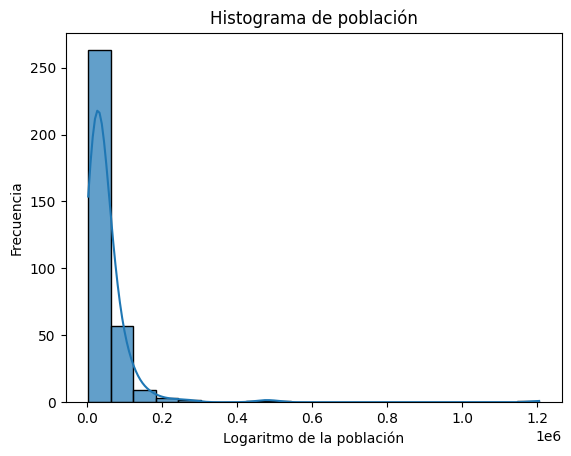

In [15]:
filtered_data = df_municipality['population'][df_municipality['population'] > 0]

# Crea el histograma con la transformación logarítmica
sns.histplot(filtered_data, bins=20, kde=True, edgecolor='black', alpha=0.7)
plt.xlabel('Logaritmo de la población')
plt.ylabel('Frecuencia')
plt.title('Histograma de población')
plt.show()

- El diagrama posee un sesgo, por lo cuál, se hará una transformación logarítmica

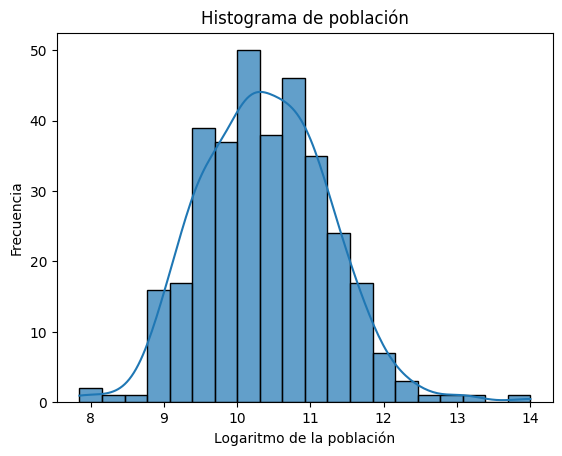

In [16]:
# Filtra los valores mayores que cero
filtered_data = df_municipality['population'][df_municipality['population'] > 0]

# Crea el histograma con la transformación logarítmica
sns.histplot(np.log(filtered_data), bins=20, kde=True, edgecolor='black', alpha=0.7)
plt.xlabel('Logaritmo de la población')
plt.ylabel('Frecuencia')
plt.title('Histograma de población')
plt.show()

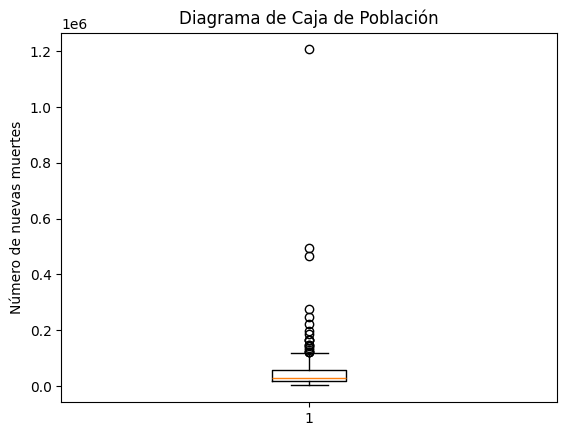

In [17]:
plt.boxplot(df_municipality['population'])

plt.title('Diagrama de Caja de Población')
plt.ylabel('Número de nuevas muertes')
plt.show()

### Diagramas de Barras para Variables cualitativas

#### Obsevaciones:
- Importante tomar en cuenta que hay municipios como San Lorenzo, Santa Barbara, San Pedro Sacatepequez, La Libertad y la Democracia que aparecen más veces en los registros, esto puede influir en los resultados finales.
- Los departamentos que mas aparecen son Huehuetenango, San Marcos y Quetzaltenango, esto no debería representar una alteración en los datos ya que esto depende de la cantidad de municipios que cada departamento tenga.

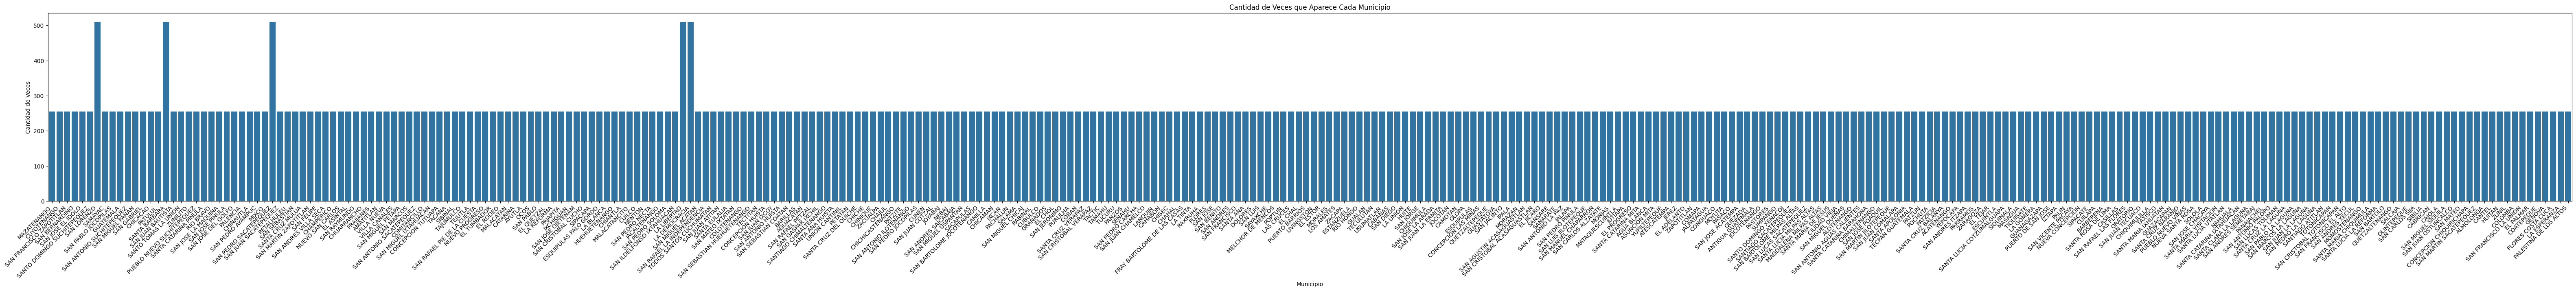

In [18]:
plt.figure(figsize=(80, 6))
sns.countplot(x='municipality_name', data=df_municipality_deaths)
plt.xticks(rotation=45, ha='right')
plt.title('Cantidad de Veces que Aparece Cada Municipio')
plt.xlabel('Municipio')
plt.ylabel('Cantidad de Veces')
plt.show()

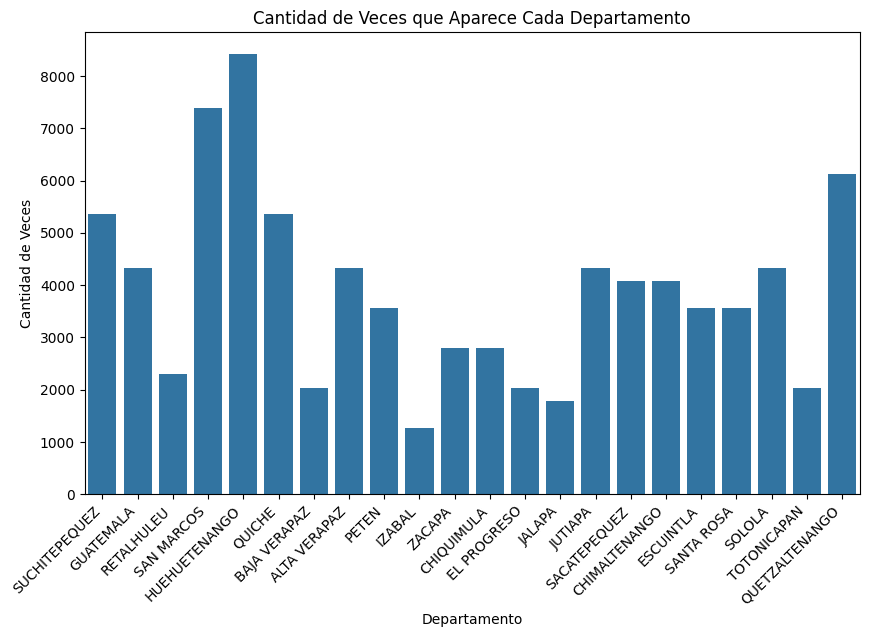

In [19]:
# Gráfica de barras para 'department_name'
plt.figure(figsize=(10, 6))
sns.countplot(x='department_name', data=df_municipality_deaths)
plt.xticks(rotation=45, ha='right')
plt.title('Cantidad de Veces que Aparece Cada Departamento')
plt.xlabel('Departamento')
plt.ylabel('Cantidad de Veces')
plt.show()

## EDA Multivariable

### Gráficas de Dispersión

#### Observaciones:
- En la grafica de dispersión, se puede observar que hay mucha acumulación de datos en valroes pequeños entre abril y junio del año 2020. Se puede ententder que en estas fechas el covid se comenzó a expandir por muchos municipios.
- Los datos son más dispersos mientras más alto es el número de nuevas muertes y mientras más avanzaba el tiempo

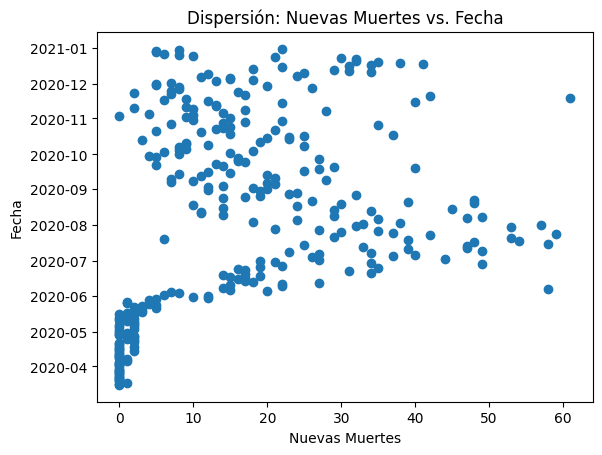

In [20]:
plt.scatter(df_country_deaths['new_deaths'], df_country_deaths['date'])
plt.xlabel('Nuevas Muertes')
plt.ylabel('Fecha')
plt.title('Dispersión: Nuevas Muertes vs. Fecha')
plt.show()

#### Observaciones
- En este caso la gráfica tiene una tendencía a parecer una gráfica lineal, ya que los deatos no suelen estar muy dispersos. Esto se debe a que al ser un gráfico de dispersión de una gráfica acumulativa, los datos se agruparán uno después de otro conforme estos se vayan incrementando.

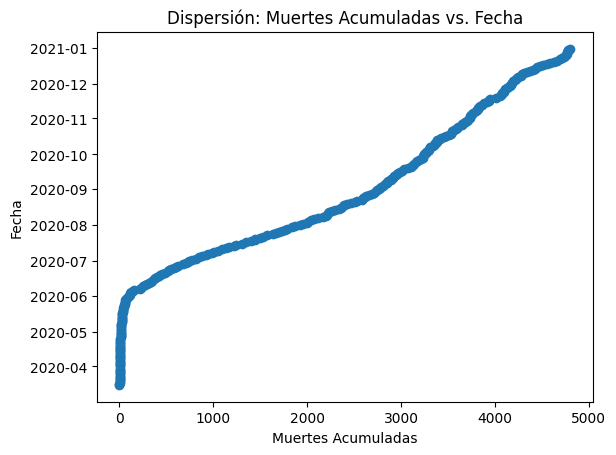

In [21]:
plt.scatter(df_country_deaths['cumulative_deaths'], df_country_deaths['date'])
plt.xlabel('Muertes Acumuladas')
plt.ylabel('Fecha')
plt.title('Dispersión: Muertes Acumuladas vs. Fecha')
plt.show()

#### Observaciones:
- Esta gráfica de dispersión nos confirma precisamente lo que se mencionaba en puntos anteriores, a pesar de que la ciudad de Guatemala es la ciudad con más habitantes en el país (con una diferencia abismal), el territorio Guatemalteco se compone en su mayoría por municipios que no poseen una población tan grande como la ciudad de Guatemala, lo cual provoca que los datos se encuentren más agrupados en la mayoría del país, mientras que la ciudad de Guatemala se encuentra demasiado dispersa.

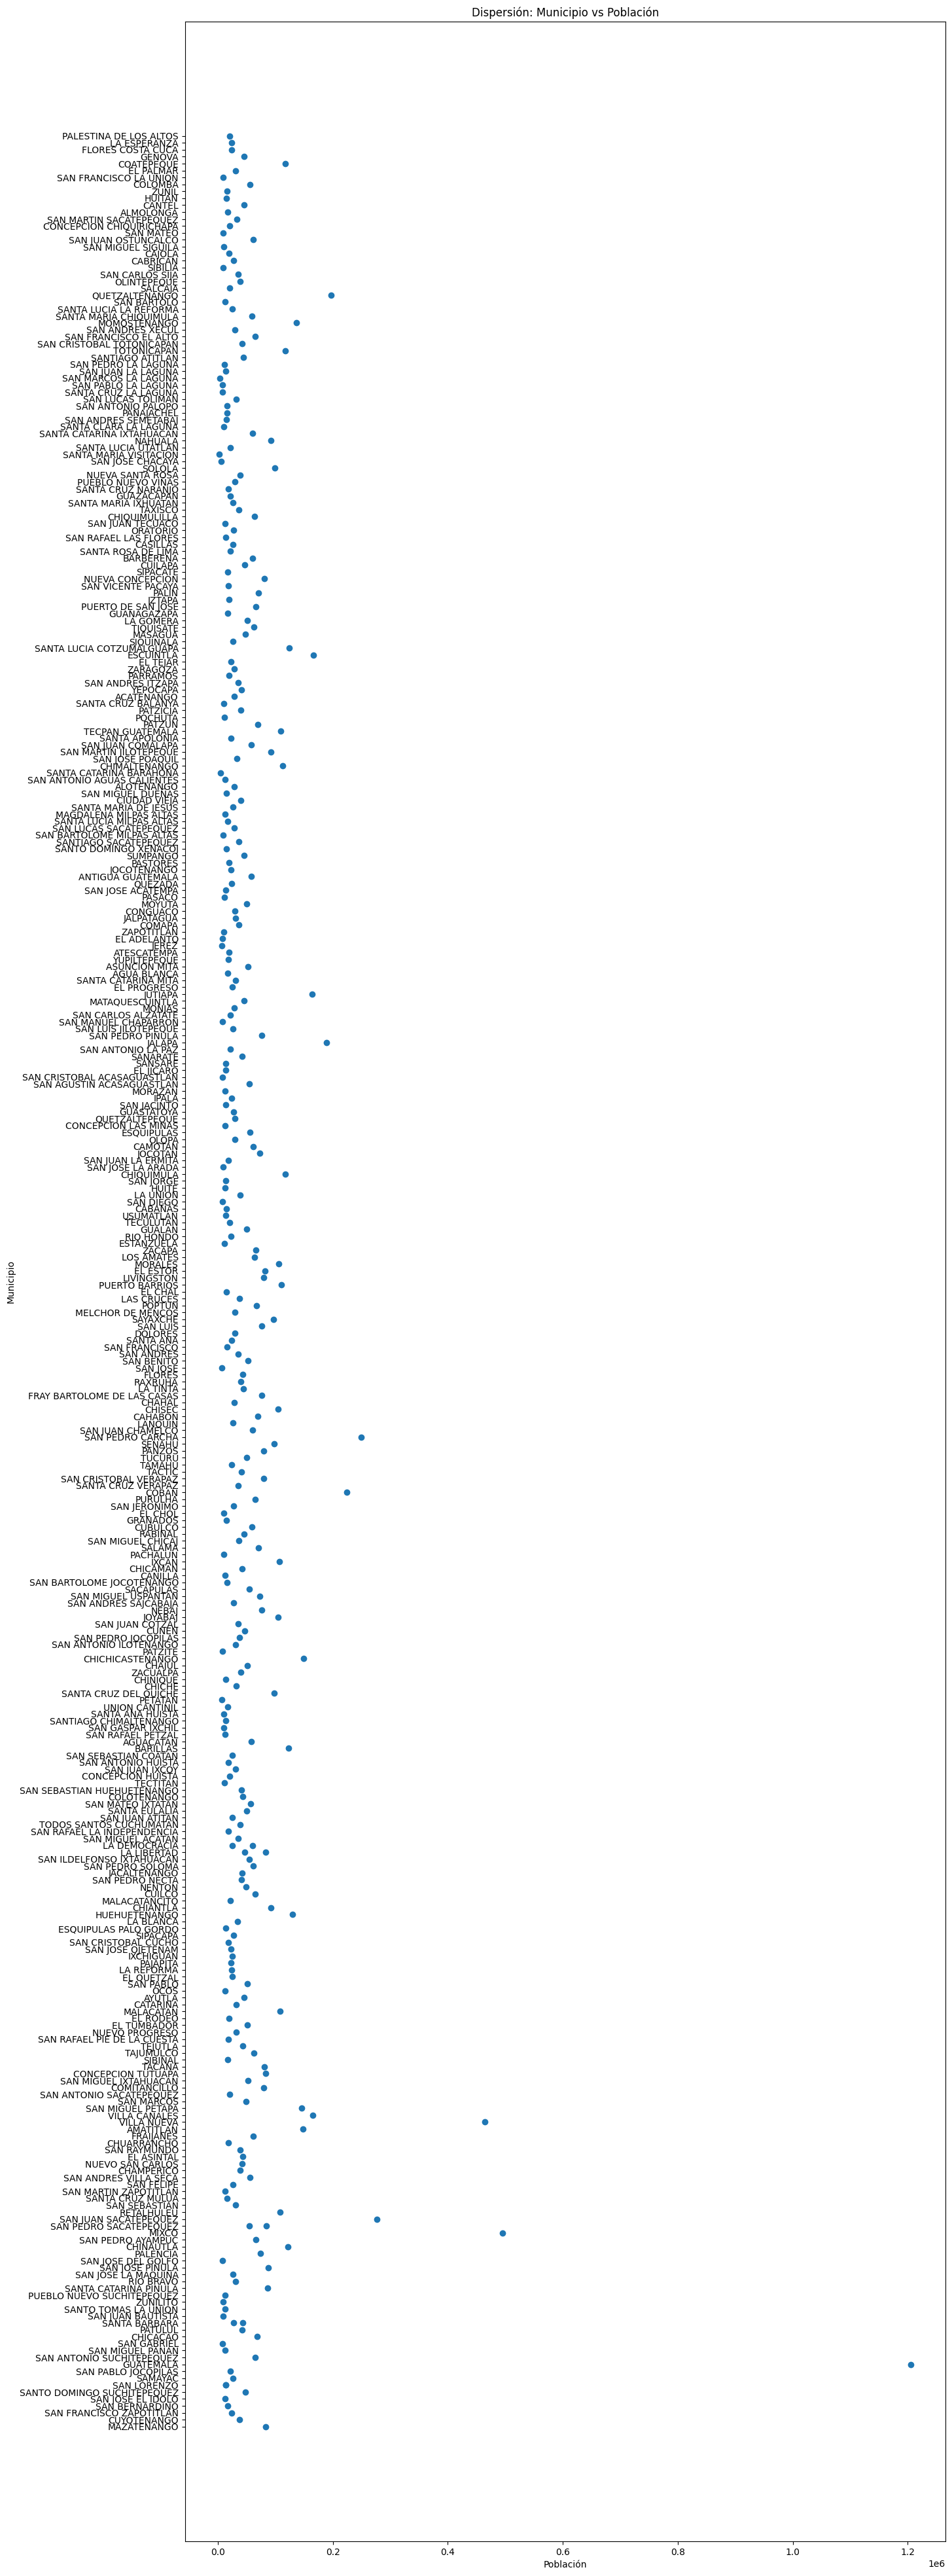

In [22]:
plt.figure(figsize=(15, 50))
plt.scatter(df_municipality['population'], df_municipality['name'])
plt.xlabel('Población')
plt.ylabel('Municipio')
plt.title('Dispersión: Municipio vs Población')
plt.show()

#### Observaciones:
- Una gráfica muy similar a la anterior, sin embargo, ahora que se analiza la población por departamento, podemos observar que los datos se encuentran más dispersos, esto se debe a que al ser porciones de territorio más grandes la diferencia entre poblaciones tiende a ser mayor.

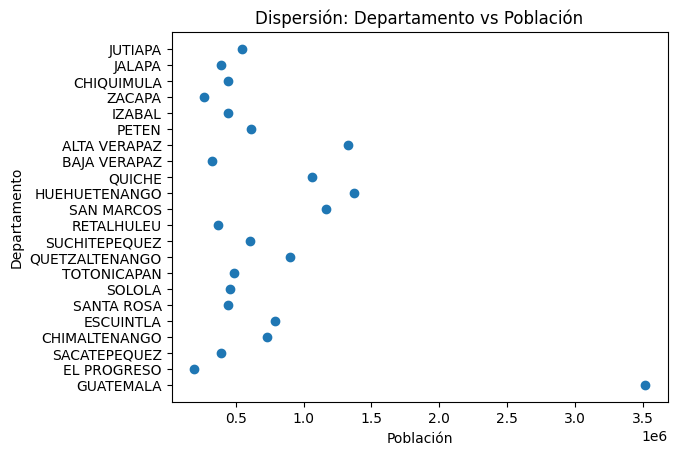

In [23]:
plt.scatter(df_department_population['TotalPopulation'], df_department_population['DepartmentName'])
plt.xlabel('Población')
plt.ylabel('Departamento')
plt.title('Dispersión: Departamento vs Población')
plt.show()

### Municipios vs Cantidad de Nuevas Muertes

#### Observaciones:
- Estas gráficas muestran la cantidad de días en los que cada municipio ha registrado al menos una muerte. En ese caso ya podemos observar algunas variaciones en comparación a las estadísticas de población, ya que, a pesar de que la ciudad de Guatemala sigue siendo el número 1, ya la diferencia se reduce bastante (principalmente porque el contexto de la gráfica es otro). 
- La gráfica también nos muestra otras variaciones, como por ejemplo la ciudad de quetzaltenango, ya que, a pesar de que es la número 7 en la gráfica de población, en esta gráfica se encuentra en el puesto 4. Esto se puede deber al comercio que se da en esta ciudad que a pesar de no tener tantos habitantes como otras ciudades, el comercio si es muy relevante.

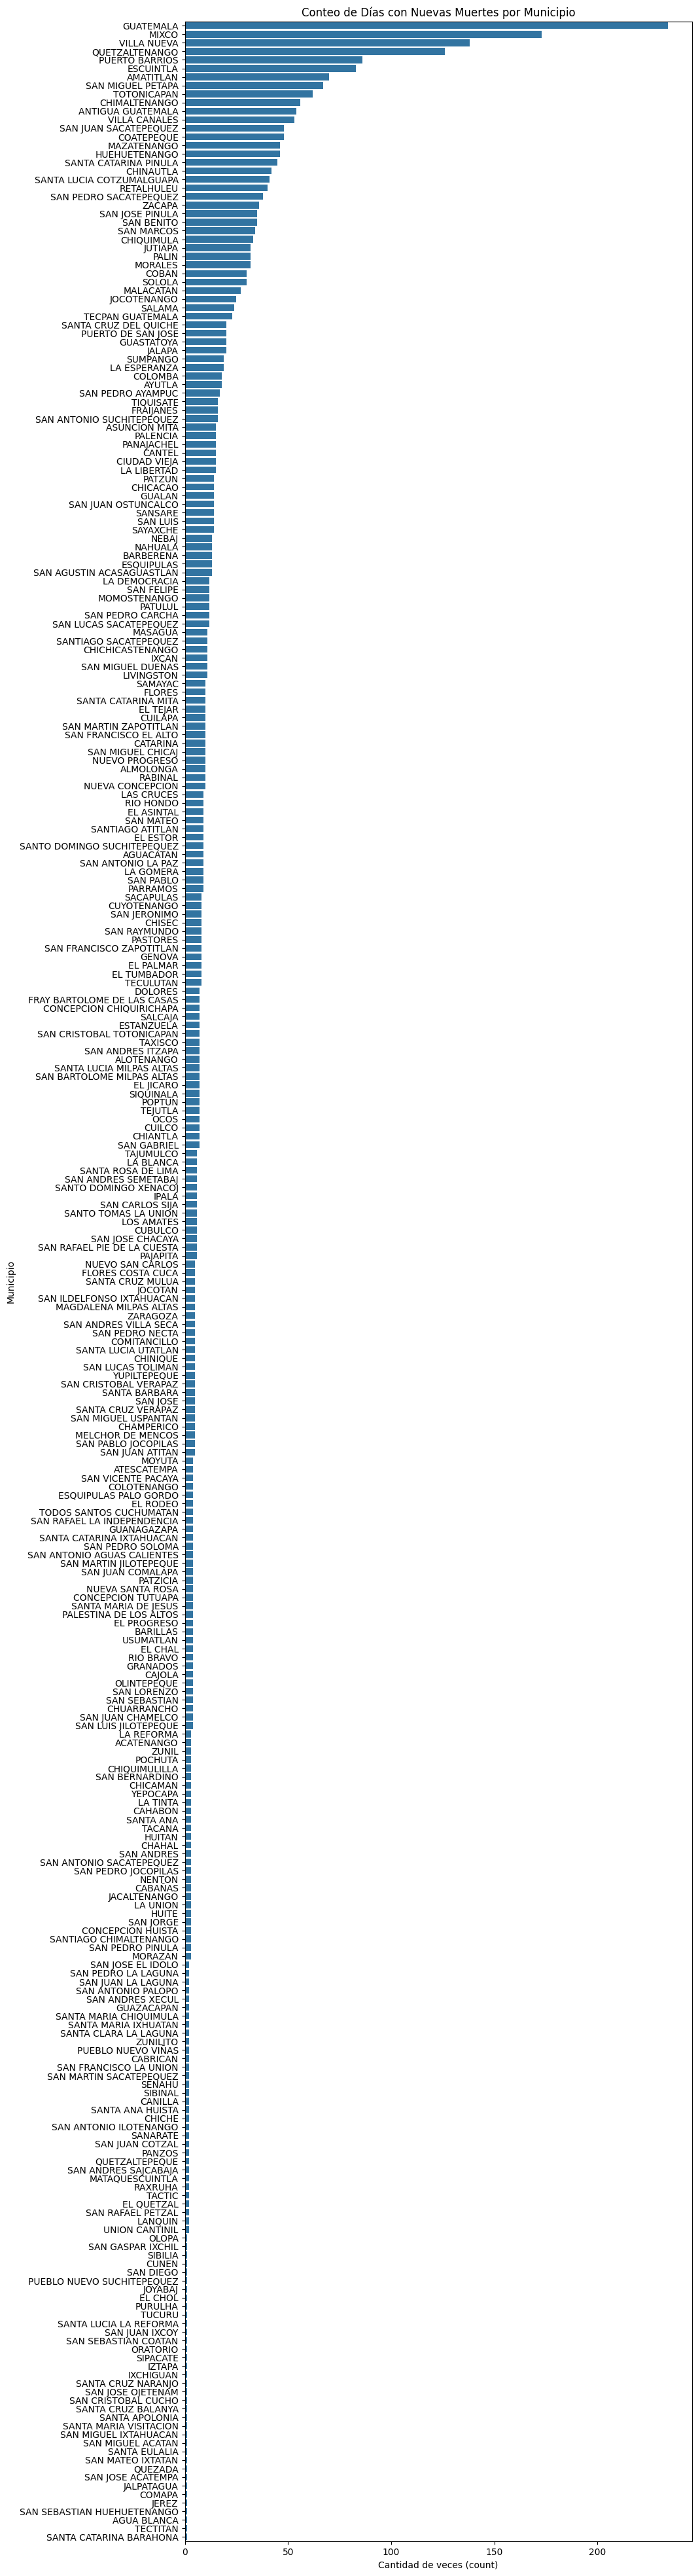

In [24]:
# Filtrar las filas donde total_deaths no es igual a cero
df_filtered = df_municipality_deaths[df_municipality_deaths['total_deaths'] != 0]

# Contar las ocurrencias de cada "name" en el DataFrame filtrado
df_municipality_count = df_filtered['municipality_name'].value_counts().reset_index()
df_municipality_count.columns = ['municipality_name', 'count']

# Crear una gráfica de barras con seaborn
plt.figure(figsize=(10, 50))
sns.barplot(x='count', y='municipality_name', data=df_municipality_count) 

# Añadir etiquetas y título
plt.xlabel('Cantidad de veces (count)')
plt.ylabel('Municipio')
plt.title('Conteo de Días con Nuevas Muertes por Municipio')

# Mostrar el gráfico
plt.show()

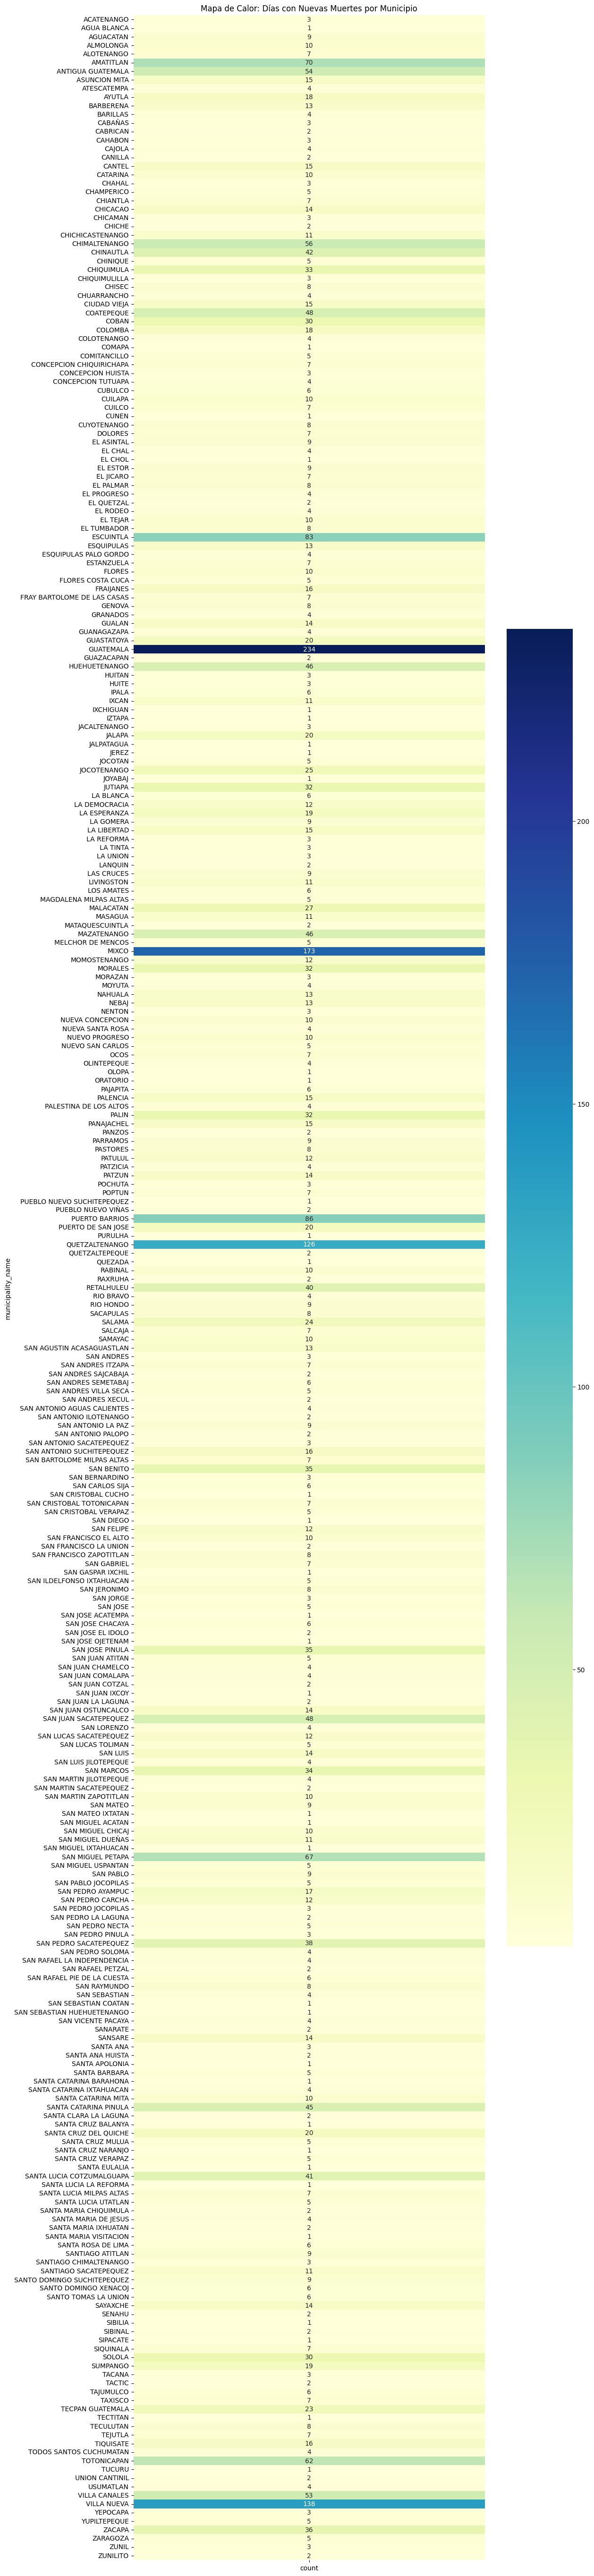

In [25]:
df_filtered = df_municipality_deaths[df_municipality_deaths['total_deaths'] != 0]

# Contar las ocurrencias de cada "name" en el DataFrame filtrado
df_municipality_count = df_filtered['municipality_name'].value_counts().reset_index()
df_municipality_count.columns = ['municipality_name', 'count']

# Crear un mapa de calor con seaborn
plt.figure(figsize=(12, 70)) 
sns.heatmap(df_municipality_count.pivot_table(index='municipality_name', values='count', aggfunc='sum'), cmap='YlGnBu', annot=True, fmt='g')

# Añadir título
plt.title('Mapa de Calor: Días con Nuevas Muertes por Municipio')

# Mostrar el gráfico
plt.show()

### Departamentos vs Nuevas Muertes

#### Observaciones:
- Gráficas con un comportamiento similar a la anterior, pero con una tendencia nuevamente al departamento de Guatemala, ya que este posee una gran cantidad de os municipios que poseían un alto indice de fallecimientos por covid.
- Podemos observar a simple vista que los departamentos con mayor presencia de municipios urbanos son aquellos que han sido más afectados. Sin embargo hay casos como el de Escuintla, donde se nota a simple vista que ha sido muy afectado, pero éste es de los pocos casos donde hay gran presencia de área rural y el covid ha afectado fuertemente.
- El caso de Escuintla puede darse debido a ser aledaño a los departamentos de Guatemala, Sacatepequez y Chimalttenango.

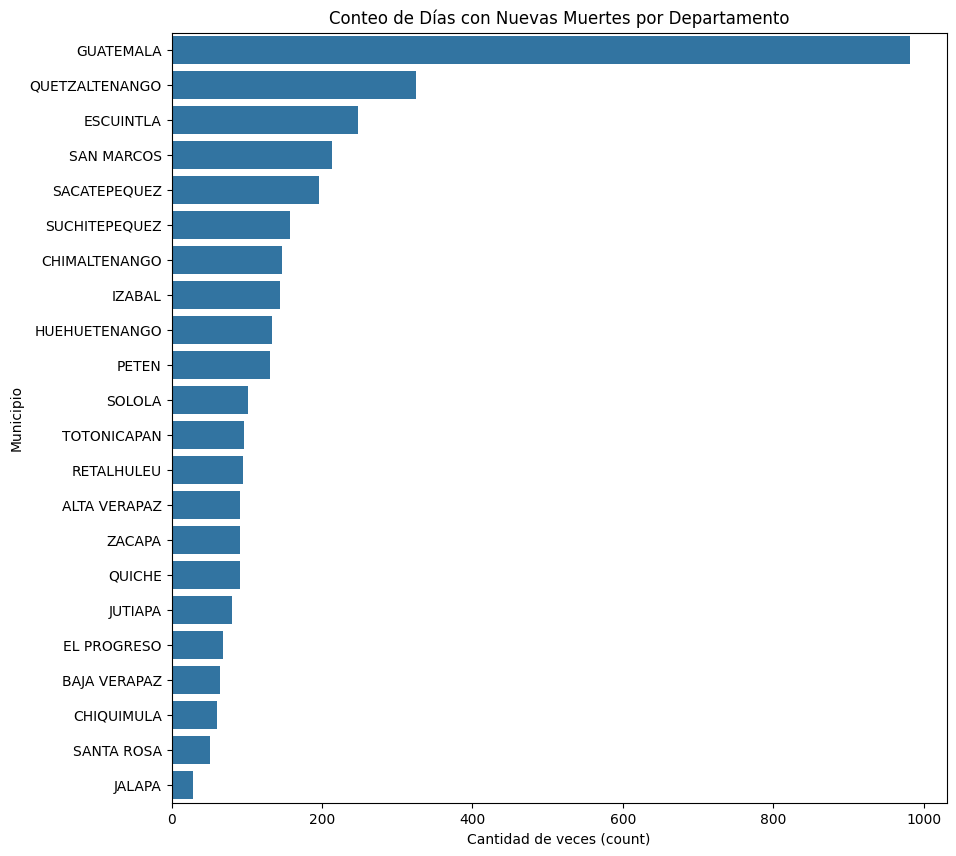

In [26]:
df_filtered = df_municipality_deaths[df_municipality_deaths['total_deaths'] != 0]

# Contar las ocurrencias de cada "name" en el DataFrame filtrado
df_municipality_count = df_filtered['department_name'].value_counts().reset_index()
df_municipality_count.columns = ['department_name', 'count']

# Crear una gráfica de barras con seaborn
plt.figure(figsize=(10, 10)) 
sns.barplot(x='count', y='department_name', data=df_municipality_count)

# Añadir etiquetas y título
plt.xlabel('Cantidad de veces (count)')
plt.ylabel('Municipio')
plt.title('Conteo de Días con Nuevas Muertes por Departamento')

# Mostrar el gráfico
plt.show()

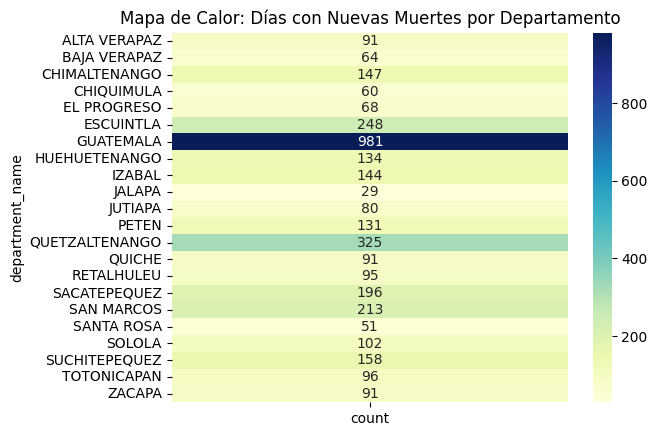

In [27]:

df_municipality_count = df_filtered['department_name'].value_counts().reset_index()
df_municipality_count.columns = ['department_name', 'count']

sns.heatmap(df_municipality_count.pivot_table(index='department_name', values='count', aggfunc='sum'), cmap='YlGnBu', annot=True, fmt='g')

# Añadir título
plt.title('Mapa de Calor: Días con Nuevas Muertes por Departamento')

# Mostrar el gráfico
plt.show()

### Municipios vs Población

#### Observaciones:
- Gráfica que denota la población de cada municipio del país, posee un comportamiento similar al de la gráfica de dispersión anteriormente monstrada.
- Podemos observar y notar a simple vista que los municipios pertenecientes al área urbana poseen la mayor concentración de pobladores, esto se da porque el comercio se da de una forma más abundante en estás áreas.

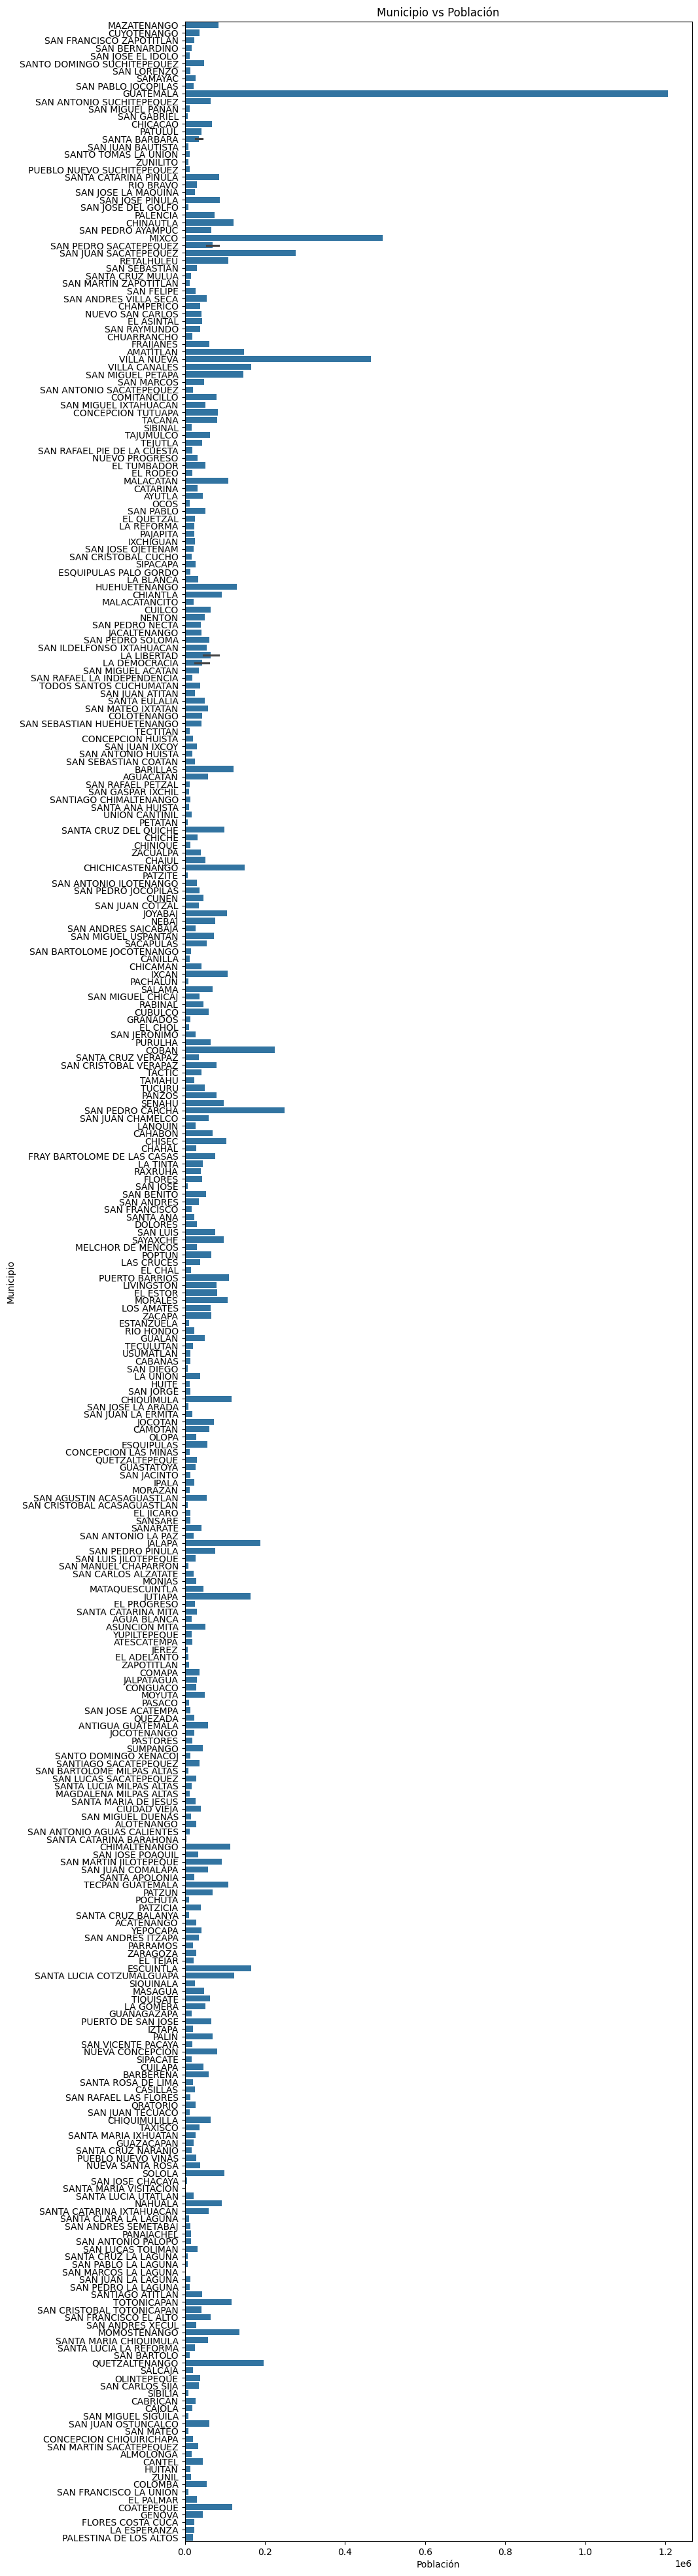

In [28]:
# Crear una gráfica de barras con seaborn
plt.figure(figsize=(10, 50))
sns.barplot(x='population', y='name', data=df_municipality)

# Añadir etiquetas y título
plt.xlabel('Población')
plt.ylabel('Municipio')
plt.title('Municipio vs Población')

# Mostrar el gráfico
plt.show()

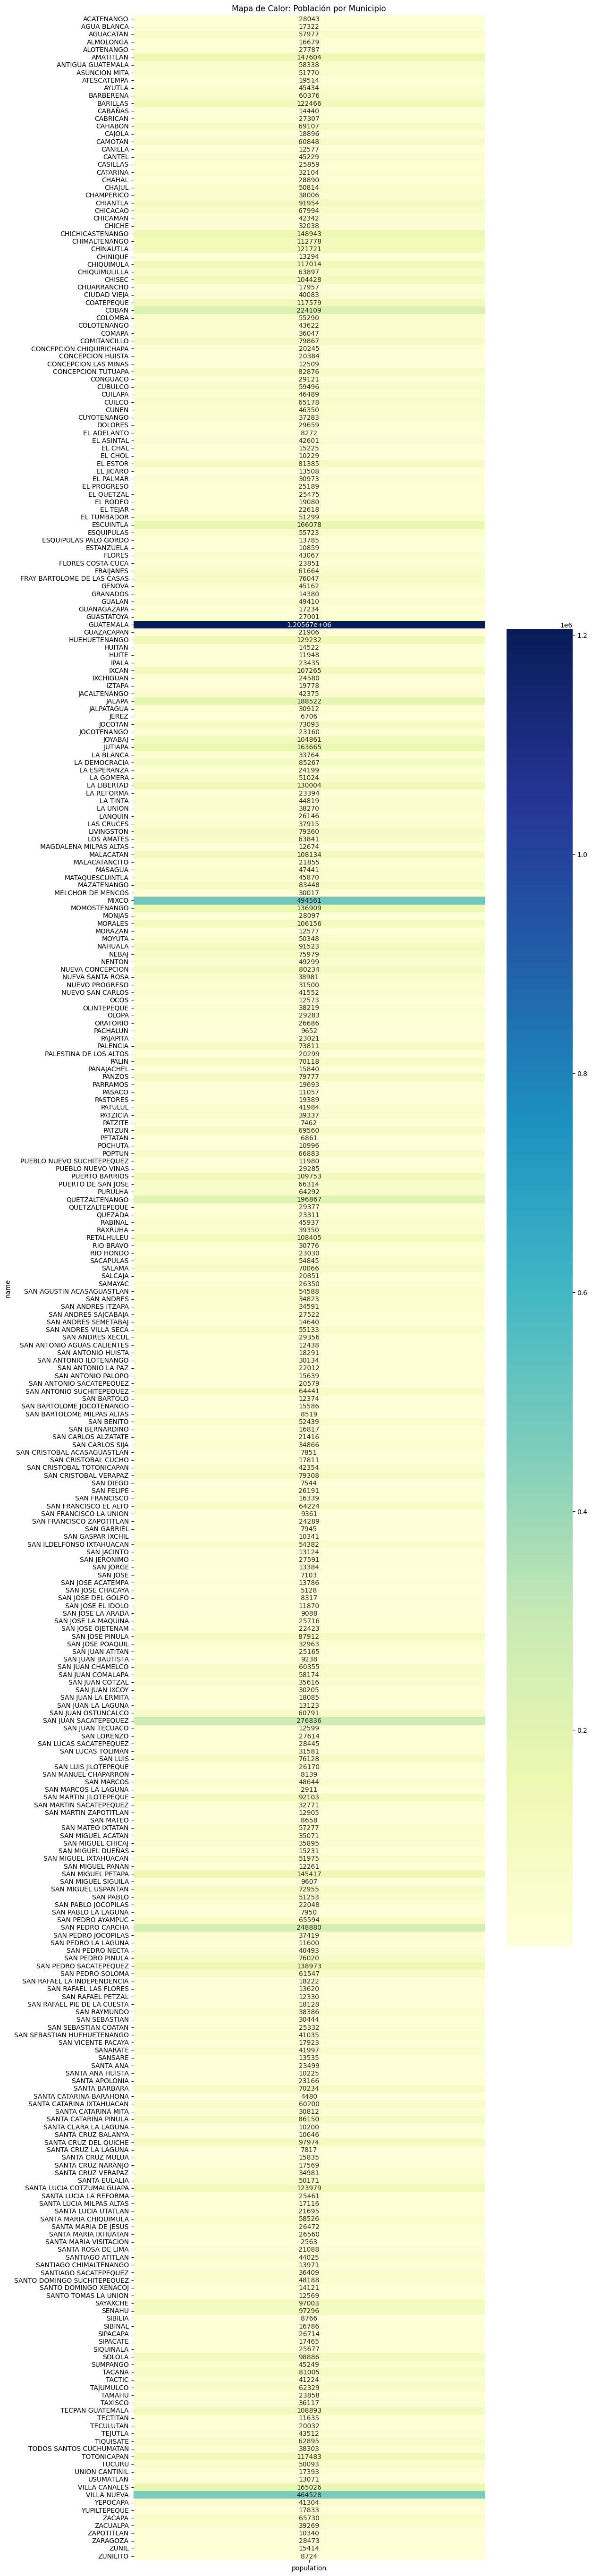

In [29]:
# Crear un mapa de calor con seaborn
plt.figure(figsize=(12, 70)) 
sns.heatmap(df_municipality.pivot_table(index='name', values='population', aggfunc='sum'), cmap='YlGnBu', annot=True, fmt='g')

# Añadir título
plt.title('Mapa de Calor: Población por Municipio')

# Mostrar el gráfico
plt.show()

### Departamento vs Población

#### Observaciones:
- Se puede observar a simple vista que la diferencia entre poblaciones es más grande cuando englobamos los departamentos, esto debido a que hay departamentos que contienen varios municipios del área urbana. 
- Se destaca el municipio de Alta Verapaz, en el cual la influencia del municipio de Cobán juega un rol muy importante para obtener una población aceptable.

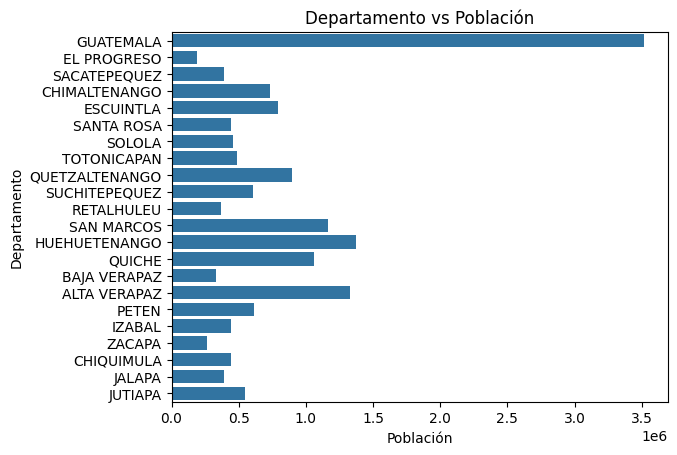

In [30]:
sns.barplot(x='TotalPopulation', y='DepartmentName', data=df_department_population) 

# Añadir etiquetas y título
plt.xlabel('Población')
plt.ylabel('Departamento')
plt.title('Departamento vs Población')

# Mostrar el gráfico
plt.show()

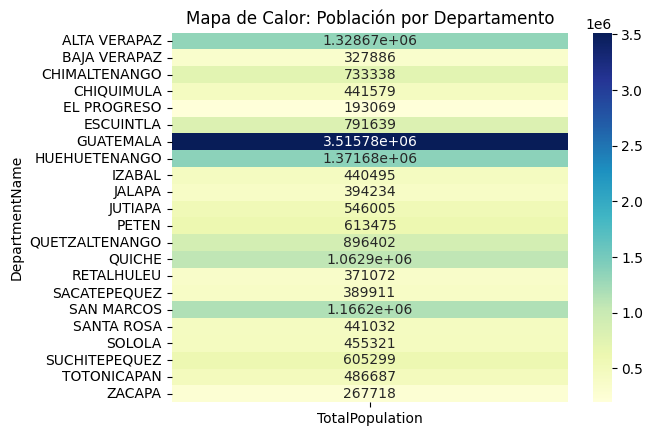

In [31]:
# Crear un mapa de calor con seaborn
sns.heatmap(df_department_population.pivot_table(index='DepartmentName', values='TotalPopulation', aggfunc='sum'), cmap='YlGnBu', annot=True, fmt='g')

# Añadir título
plt.title('Mapa de Calor: Población por Departamento')

# Mostrar el gráfico
plt.show()

### Municipio vs Muertes Acumuladas

#### Observaciones:
- La situación de los municipios de Guatemala, Mixco y Villa Nueva es sumamente preocupante, ya que la cantidad de personas que han fallecido es muy grande, si bien, es cierto que esto se debe a su población es considerablemente mayor, estamos hablando de vidas humanas, por lo cual es necesario implementar medidas para evitar que sigan multiplicandose.
- Si obviamos estos 3 municipios, también debemos centrarnos en el municipio de quetzaltenango, ya que a pesar de que la cantidad de fallecidos es por mucho, menor a Guatemala, Mixco y Villa Nueva, quetzaltenango ya se encamina a un incremento de fallecimientos.

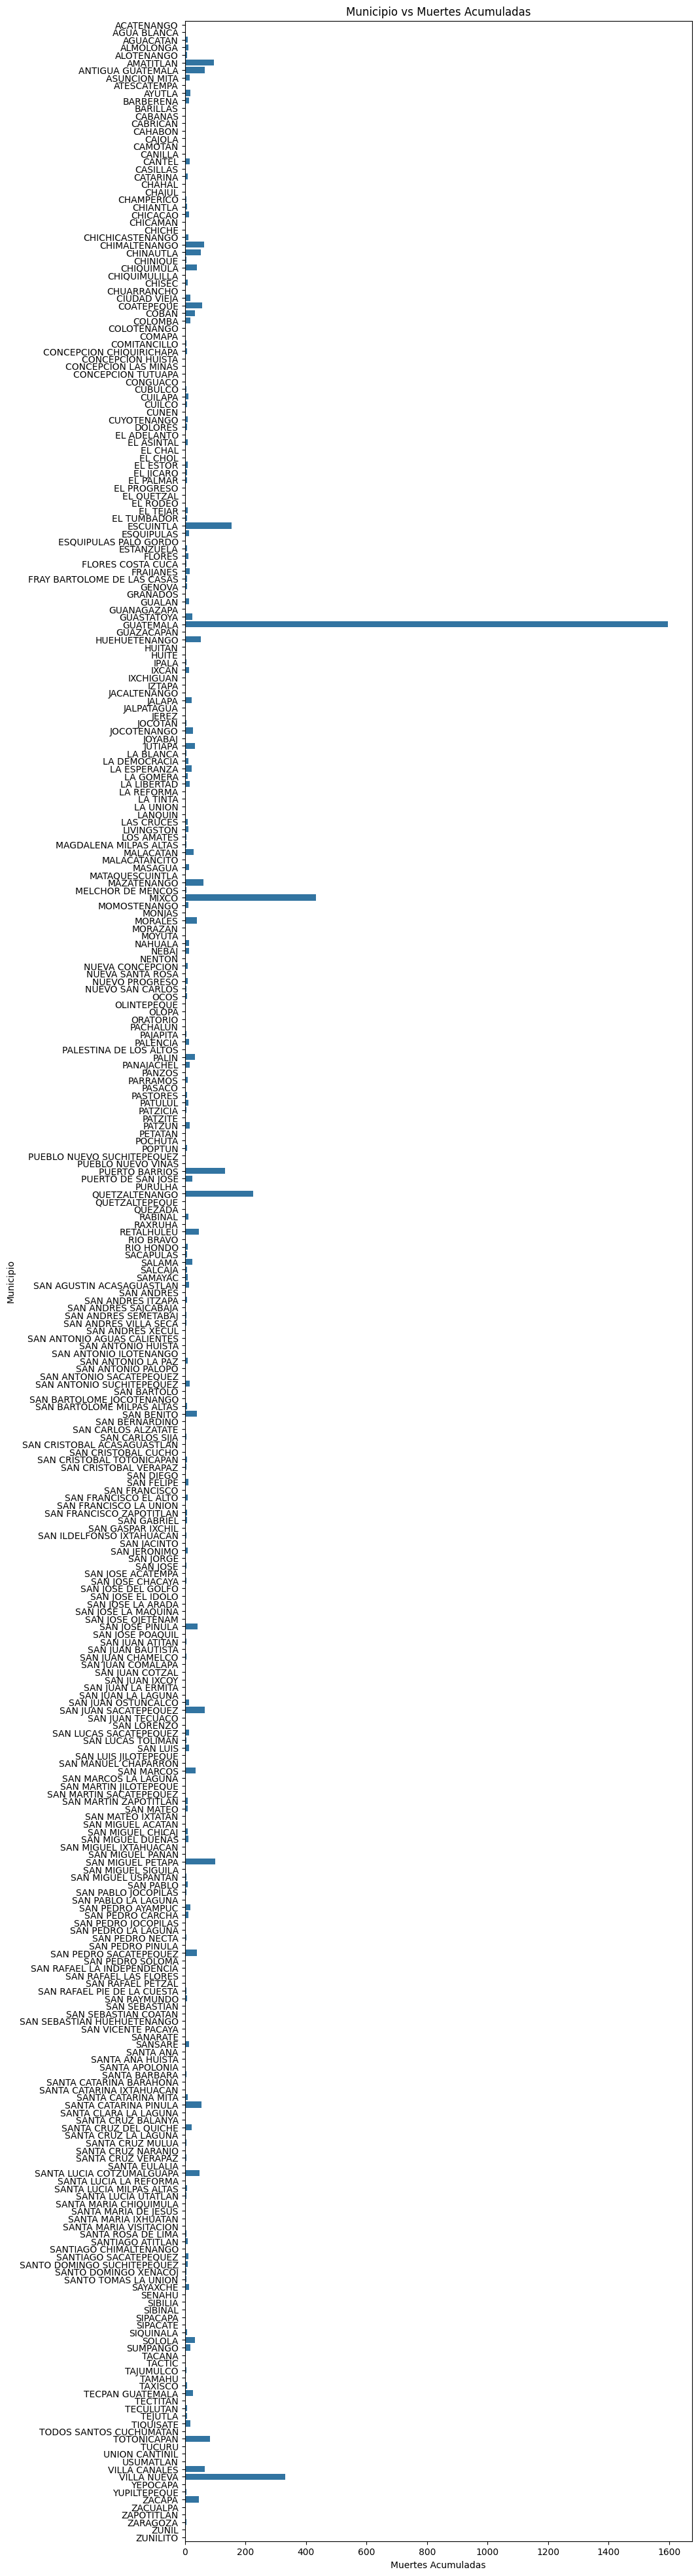

In [32]:

sum_deaths_by_municipality = df_municipality_deaths.groupby('municipality_name')['total_deaths'].sum().reset_index()

plt.figure(figsize=(10, 50))
sns.barplot(x='total_deaths', y='municipality_name', data=sum_deaths_by_municipality) 

# Añadir etiquetas y título
plt.xlabel('Muertes Acumuladas')
plt.ylabel('Municipio')
plt.title('Municipio vs Muertes Acumuladas')

# Mostrar el gráfico
plt.show()

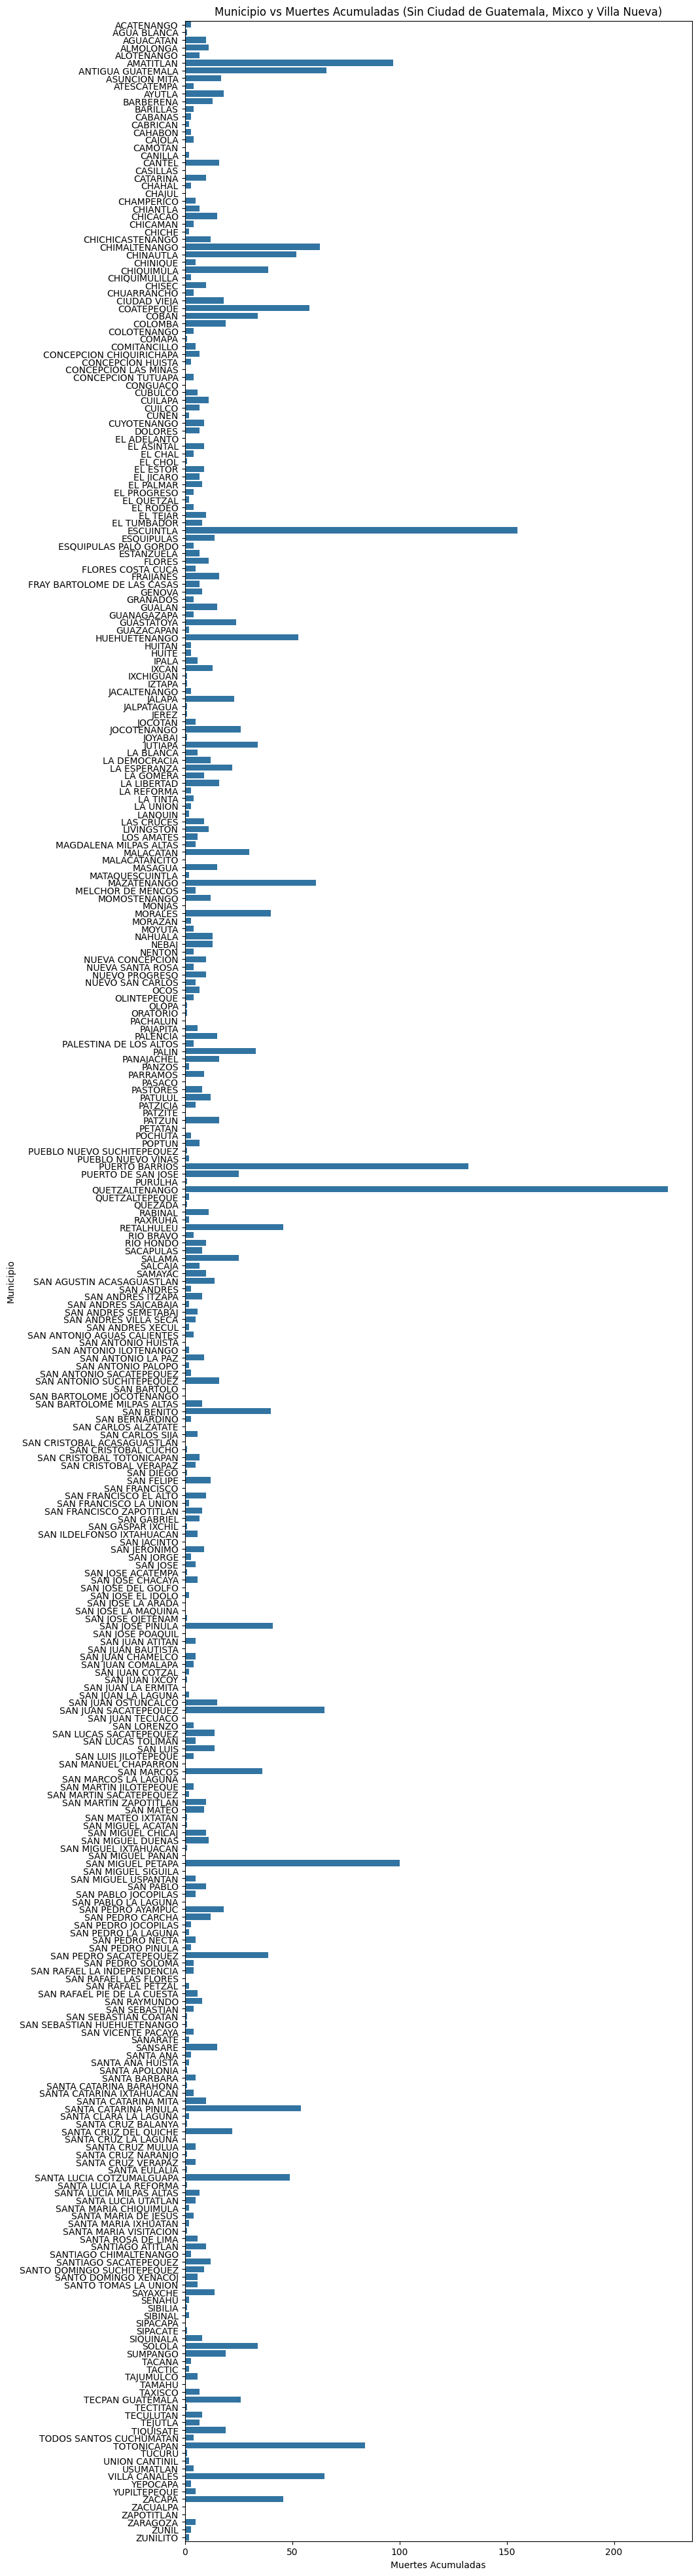

In [33]:
# Filtrar las filas donde "municipality_name" no sea igual a "GUATEMALA" "MIXCO" O "VILLA NUEVA"
df_filtered = df_municipality_deaths.query('municipality_name not in ["GUATEMALA", "MIXCO", "VILLA NUEVA"]')

# Agrupar por "municipality_name" y sumar la cantidad total de muertes
sum_deaths_by_municipality = df_filtered.groupby('municipality_name')['total_deaths'].sum().reset_index()

plt.figure(figsize=(10, 50))
sns.barplot(x='total_deaths', y='municipality_name', data=sum_deaths_by_municipality) 

# Añadir etiquetas y título
plt.xlabel('Muertes Acumuladas')
plt.ylabel('Municipio')
plt.title('Municipio vs Muertes Acumuladas (Sin Ciudad de Guatemala, Mixco y Villa Nueva)')

# Mostrar el gráfico
plt.show()

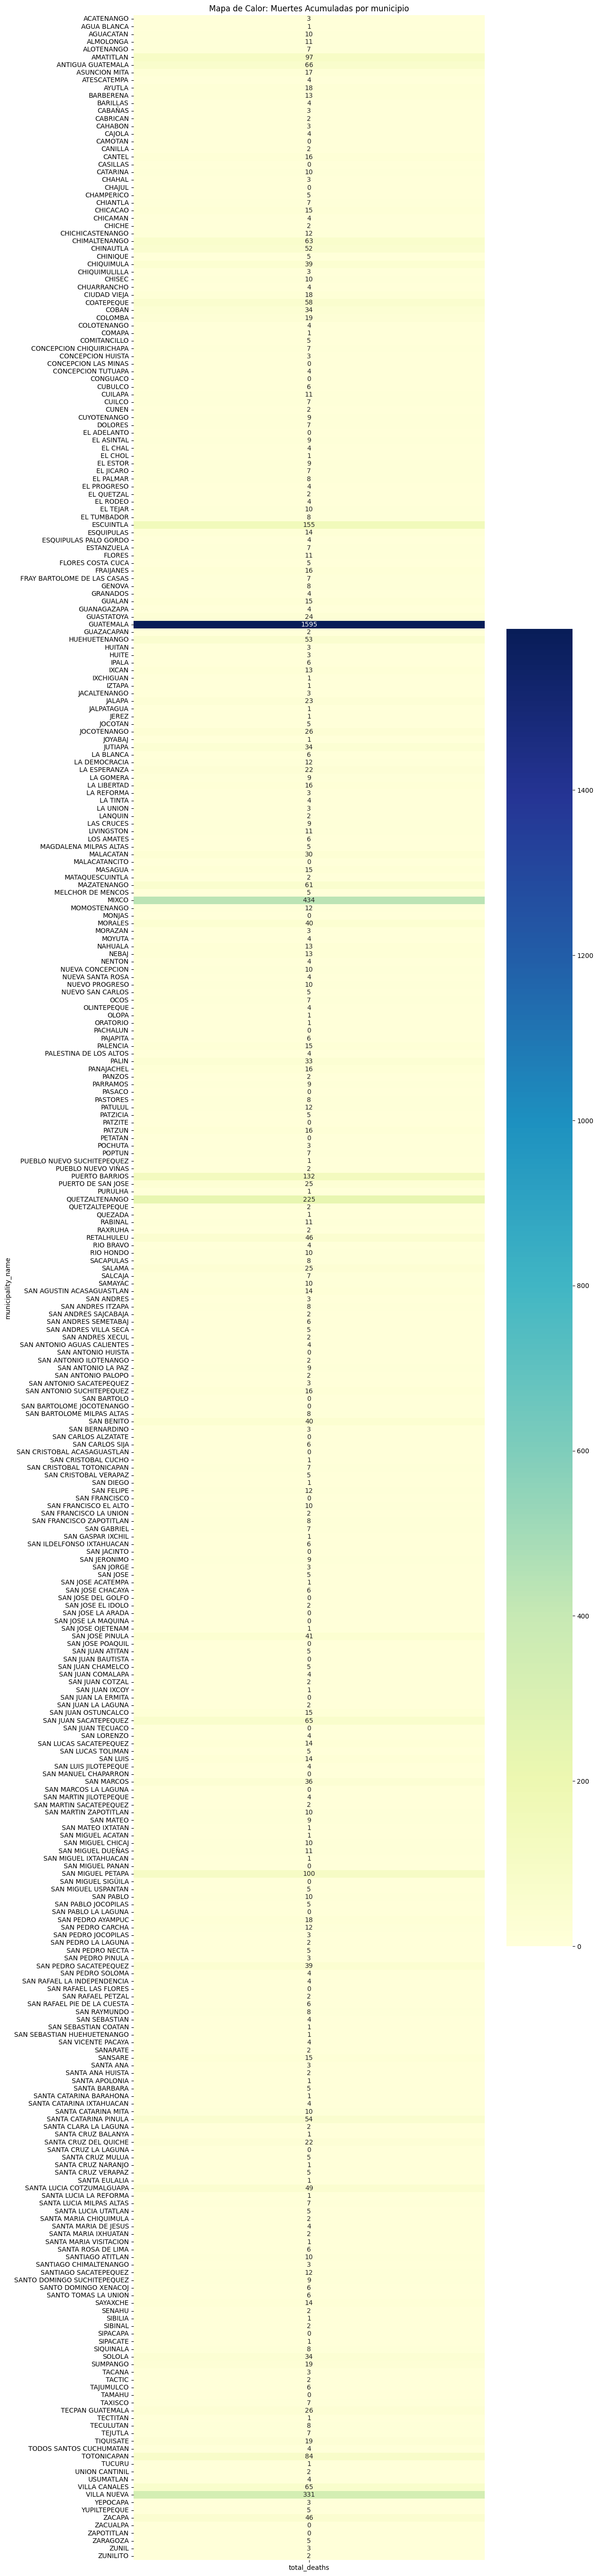

In [34]:
sum_deaths_by_municipality = df_municipality_deaths.groupby('municipality_name')['total_deaths'].sum().reset_index()

plt.figure(figsize=(12, 70)) 
# Crear un mapa de calor con seaborn
sns.heatmap(sum_deaths_by_municipality.pivot_table(index='municipality_name', values='total_deaths', aggfunc='sum'), cmap='YlGnBu', annot=True, fmt='g')

# Añadir título
plt.title('Mapa de Calor: Muertes Acumuladas por municipio')

# Mostrar el gráfico
plt.show()

### Departamento vs Muertes Acumuladas

#### Observaciones:
- Además de la casi obvia situación del departamento de Guatemala, la gráfica también nos denota ver la situación del departamento de Quetzaltenango, ya que en anteriores gráficas pudimos ver que solo en el municipio de quetzaltenango habían aproximadamente 250 fallecimientos, mientras que aquí podemos ver que el departamento de quetzaltenango completo tiene aproximadamente 450 muertes, lo cual nos indica que la mayor parte proviene de la cabecera municipal.
- Importante destacar el manejo de la pandemia en departamentos como Jalapa o Santa Rosa, los cuales no reportan grandes cantidades de fallecimiento, por lo que se recomienda continuar con este número bajo de fallecimientos

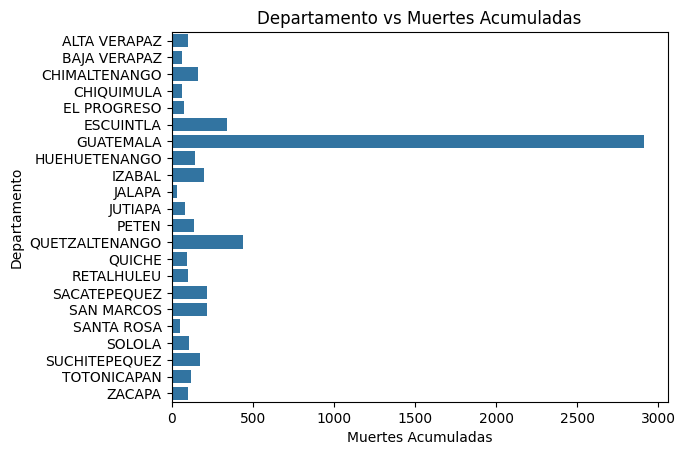

In [35]:
sum_deaths_by_municipality = df_municipality_deaths.groupby('department_name')['total_deaths'].sum().reset_index()

sns.barplot(x='total_deaths', y='department_name', data=sum_deaths_by_municipality) 

# Añadir etiquetas y título
plt.xlabel('Muertes Acumuladas')
plt.ylabel('Departamento')
plt.title('Departamento vs Muertes Acumuladas')

# Mostrar el gráfico
plt.show()

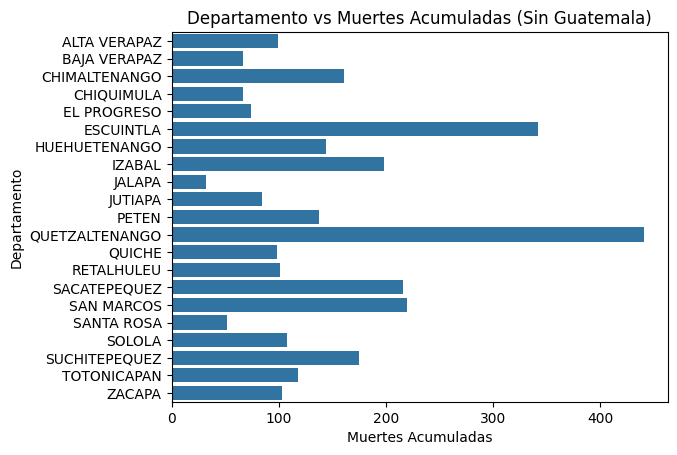

In [36]:
# Filtrar las filas donde "municipality_name" no sea igual a "GUATEMALA" Transformación
df_filtered = df_municipality_deaths.query('department_name not in ["GUATEMALA"]')

# Agrupar por "municipality_name" y sumar la cantidad total de muertes
sum_deaths_by_municipality = df_filtered.groupby('department_name')['total_deaths'].sum().reset_index()

sns.barplot(x='total_deaths', y='department_name', data=sum_deaths_by_municipality) 

# Añadir etiquetas y título
plt.xlabel('Muertes Acumuladas')
plt.ylabel('Departamento')
plt.title('Departamento vs Muertes Acumuladas (Sin Guatemala)')

# Mostrar el gráfico
plt.show()

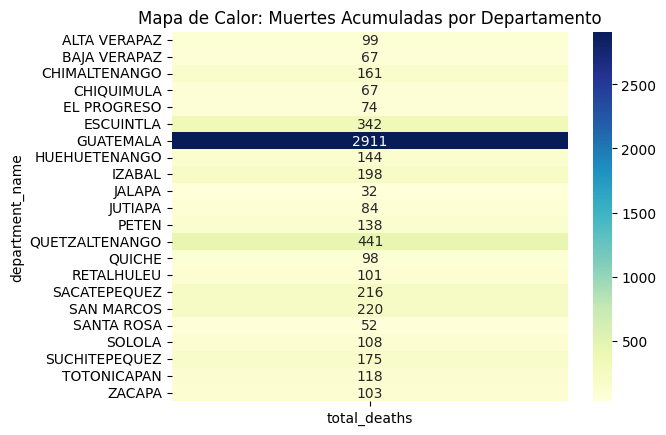

In [37]:
sum_deaths_by_municipality = df_municipality_deaths.groupby('department_name')['total_deaths'].sum().reset_index()

# Crear un mapa de calor con seaborn
sns.heatmap(sum_deaths_by_municipality.pivot_table(index='department_name', values='total_deaths', aggfunc='sum'), cmap='YlGnBu', annot=True, fmt='g')

# Añadir título
plt.title('Mapa de Calor: Muertes Acumuladas por Departamento')

# Mostrar el gráfico
plt.show()

### Transformaciones
Durante el proceso se realizaron las siguientes transformaciones:
1. Uso de función logarítmica en histograma de población debido a sesgo en la gráfica
2. Para la gráfica de Municipios vs Muertes Acumuladas se eliminó a los municipios de Guatemala, Mixco y Villa Nueva, debido a que contaban con poblaciones muy grandes en comparación con los demás municipios (eran valores atípicos).
3. Para la gráfica de Departamentos vs Muertes Acumuladas se eliminó al departamento de Guatemala debido a que su población era mucho más grande en comparación a los demás departamentos (era un valor atípico).

Nota: No se hicieron más transformaciones ya que las demás estadisticas cumplían su propósito.

## Conclusiones:
En base a los datos estadísticos analizados anteriormente se puede concluir lo siguiente:
1. Los municipios que fueron más afectados durante la pandemia COVID-19, fueron aquellos pertenecientes al área urbana y esto puede ser consecuencia del estilo de vida que las personas tienen en estas áreas, además de la población tan grande que habita estos lugares. Esto se puede deber a razones como la construcción de cada municipio, ya que a pesar de que se considera que el área rural cuenta con menos educación escolar, el área rural se compone en su mayoría por espacios abiertos donde el aire puede circular con mayor facilidad (además de las campañas de protección contra el covid que se hicieron en estos lugares); mientras que el área urbana a pesar de contar con mejores oportunidades en la educación escolar, tiende a tener lugares con demasiado comercio (negocios) los cuales son lugares en su mayor parte cerrados y donde surge aglomeración de personas, los cuales son lugares donde el aire no puede circular con libertad y esto puede provocar que los contagios sean más masivos.

2. Es bien sabido que el comercio no se puede detener por el bien de la economía del país, sin embargo, también es importante velar por la vida de nuestros habitantes, por lo cual es necesario motivar a comerciantes a optar por medidas de prevención a la hora de hacer comercio. Tales medidas pueden ser llevar a cabo reuniones virtuales, comercio al aire libre, el uso de protocolos de bioseguridad y sobre todo evitar las aglomeraciones.

3. Los municipios del área rural que fueron más afectados durante la pandemia COVID-19 han sido chinautla, coatepeque, huehuetenango, puerto barrios, santa catarina pinula, santa lucía cotzumalguapa, totonicapan, zacapa. Es importante tener en observación a estos municipios, ya que tienen tendencias a seguir incrementando el número de fallecimientos. Es importante reforzar la educación escolar sanitaria en estos municipios para seguir preveniendo la pandemia y futuras enfermedades también.

4. Existen varios municipios aún (2020) que no cuentan con fallecimientos registrados, por lo que es importante estudiar la conducta de dichos municipios para verificar que las personas realmente no están falleciendo de covid, y de ser veridica esta información, también es importante estudiar dichos municipios (o departamentos como Jalapa y Santa Rosa) para identificar conductas que evitan dichos contagios y poder replicarlas en áreas más grandes como pueden ser la ciudad capital, villa nueva, mixco o quetzaltenango.

5. Importante seguir incentivando al acatamiento de medidas de prevención a los departamentos/municipios que han logrado contener la pandemia y así seguir evitando que los fallecimientos se incrementen de manera abismal, además, también es importante seguir incentivando un estilo de vida preventivo y saludable para tener una mejor calidad de vida en caso de aparición de futuras enfermedades.